## Problem 

### The problem being examined today is customers leaving the telco firm. This is referred to as 'churn.' We know that customers leave, but the firm would like to understand why it is that they leave. While customers can leave for any reason at any time, there are factors which will influence their choice to leave. This presentation will seek to understand and predict, to some degree, factors that the telco firm has control over which may lead to customers leaving them. 

In [1]:
# standard modules
import seaborn as sns
import pandas as pd
import numpy as np
import os
#import math

# Modules for Displaying Figures
import matplotlib.pyplot as plt
import scipy.stats as stats


# Data Science Modules 
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# My modules
import src.acquire as ac
import src.prepare as pp
import src.helper as helper
import src.evaluate as evaluate

# Turn off the red warnings
import warnings
warnings.filterwarnings("ignore")

The following datasets are available:
telco


In [2]:
# quick data acquisition
telco = ac.get_telco_data()

## Hypothesis from theory:
- tenure will have a relationship with churning (longer a customer, less likely to leave)
- price will have a relationship with churning (the higher the price, the more likely a person is to leave)
- tenure and price will correlate, showing a relationship where one effects the other 

## Dictionary of key features in data:
>>
churn - Customers who left telco  
tenure - The duration a customer stayed with telco in the 6 year window  
monthly_charges - the amount charged to the customer for services which telco provided  
>>

- Several other desciptive features per customer remain in the dataset but they are not theoretically important for our model. Those features will undoutably have issues with multicollinearity which our currently used tools can not adequately handle the issue which will be addressed at the end. For now, understand we can only mitigate the issue with a simple model. 

- Besides, a simple model performs quickly. 

In [3]:
demo = telco[['tenure','monthly_charges','contract_type']].groupby(['contract_type']).mean()
#demo = telco.groupby(['contract_type']).mean().drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id', 'senior_citizen'])
round(demo,2)

,tenure,monthly_charges
contract_type,,
Month-to-month,18.04,66.40
One year,42.04,65.05
Two year,56.74,60.77


In [4]:
correlate = telco[['churn','monthly_charges','tenure']]
round(correlate.corr(),2)

,monthly_charges,tenure
monthly_charges,1.00,0.25
tenure,0.25,1.00


In [5]:
# begin gathering our data and transforming it to useful for analysis
train, validate, test, x_train, y_train, x_validate, y_validate, x_test, y_test = pp.model_telco_data(telco)
base = evaluate.baseline(telco, 'churn')

# running models before discussion begins
decision_tree = evaluate.decision_tree_model(x_train, y_train, x_test, y_test)
knn7 = evaluate.knn7_model(x_train, y_train, x_test, y_test)
knn10 = evaluate.knn10_model(x_train, y_train, x_test, y_test)
models_compared = [base, decision_tree, knn7, knn10]
telco = ac.get_telco_data()

In [6]:
telco.groupby(['churn']).sum()

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,tenure,monthly_charges
churn,,,,,,
No,12920,9799,9775,666,194387,316985.75
Yes,3389,3392,2131,476,33603,139130.85


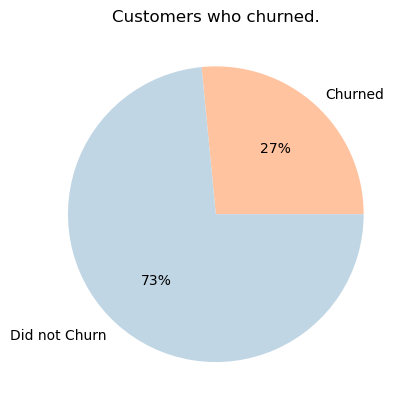

In [7]:
evaluate.make_pie(telco, 'churn')

### Based on our graphic, we can see that a lot of telco's customers churned. This is what we will be investigating.

## Run Tests to determine significance of prospective variables our hypothesis told us were important

#### First, tenure's relationship to churn

In [8]:
tenure_t, tenure_p = evaluate.get_t_score(telco, 'tenure', 'churn')
print(f't = {abs(tenure_t):.2f}')
print(f'p = {tenure_p:.2f}')
#2.015

t = 31.58
p = 0.00


- With this score, there is a zero percent chance of there being a random sampling error. Based on our data, there is relationship between tenure and churn

#### Next, we evaluate the relationship between cost and churn. Monthly charges is the metric which explains how must a customer paid, on average during their tenure with the telco

In [9]:
month_t, month_p = evaluate.get_t_score(telco, 'monthly_charges', 'churn')
print(f't = {abs(month_t):.2f}')
print(f'p = {month_p:.2f}')

t = 16.54
p = 0.00


In [10]:
t_test_comp = [2.015, abs(tenure_t),abs(month_t)]

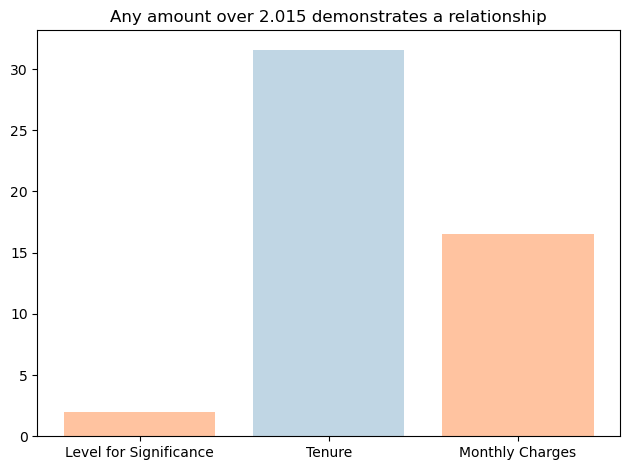

In [11]:
evaluate.t_test_bar(t_test_comp)

- With this score, there is a zero percent chance of there being a random sampling error. Based on our data, there is a relationship between monthly charges and churn

## Modeling

### We will be using our hypothesized variables, tenure, monthly charges and several others from our initial dataset. While we did not test each variable for significance, it may be the case that with our machine learning algorithms, some kind of relationship may be able to be determined - regardless of how small.

### In order to make a machine learning model which is useful, we first determine a benchmark that the model must be able to outperform.

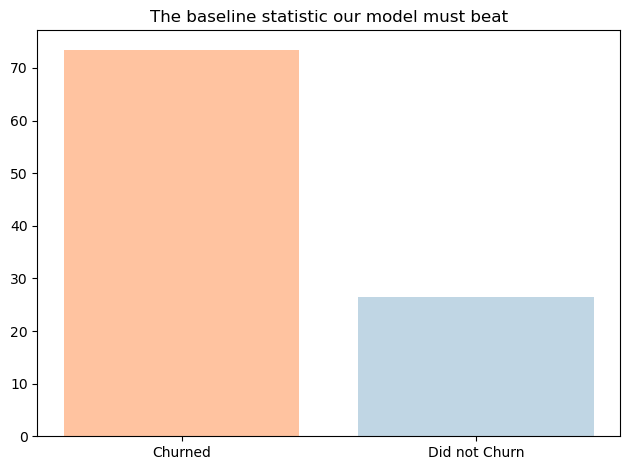

Baseline accuracy is 73.46%


In [12]:
evaluate.baseline_bar(base)
print(f"Baseline accuracy is {round(evaluate.baseline(telco, 'churn')*100,2)}%")

### We developed three models. Two based on the same algorithm, KNN and One based on a decision tree. The performance of the models is presented below

[73.46, 77.9, 76.69, 78.54]


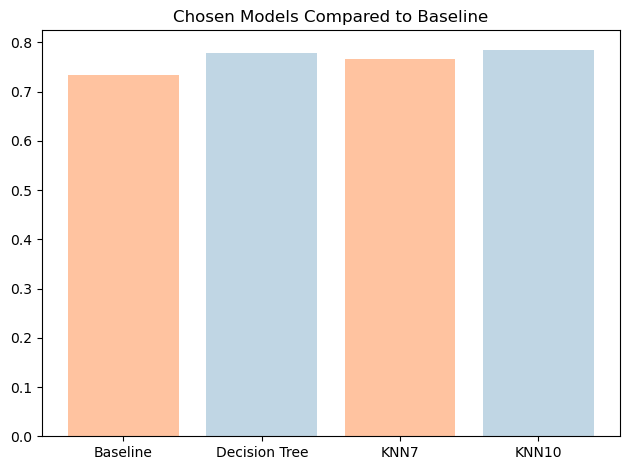

In [13]:
print(list(np.around(np.array(models_compared)*100, 2)))
evaluate.models_bar(models_compared)

In [14]:
print(list(np.around(np.array(models_compared)*100, 2)))

[73.46, 77.9, 76.69, 78.54]


In [18]:
round(knn10-base,2)

0.05

# Based on the Models created, the KNN10 is best at predicting churn from customers. It beats the baseline by 5%.

In [16]:
round(evaluate.potential_income(),2)

114276.91

## What does that tell us? 

- First, it says that the customers who are with telco are less likely to leave after they have been there for a while. It may be the case that they feel comfortable and do not want to shop around for better deals. Or perhaps, the inconvenience of uninstalling and reinstalling a different service provider's offerings is greater than their desire to leave. 

- Next, price of services matter too. We found monthly charges to have a relationship to churn, so it may be the case that in order to 'lock down' telco's customers, a lower price may be used to keep the customer around for a while. 

- I project that using our thought experiment, that we might be able to capture about 5% of our churned customers using promotions or discounts or other methods to reduce price for customers who have shorter duration tenure with telco. If that is the case, over the past 6 year cycle, we would have earned an roughly $114,276 in addition to our actual earnings.

## Next Steps

- We have a model which can be implemented now. It tells us that we should keep prices down and that our customers who stay longer will stay longer. We can do something with that.   

- We can build a better, stronger model using linear regression for multivariate analysis between the customer features to deal with our statistical problem(s) from earlier. It might provide for us better ideas of what can be done to retain customers longer.